## Assessment of study-dataset splitting

<b>source:</b> "https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/1_building_and_annotating_the_atlas_core/01b_study_splitting_by_batch_effect_assessment.ipynb"

In this notebook we will determine which of the studies that have substantial differences in experimental conditions within study will need to be split into separate datasets (datasets will be the "batches" used for integration).

### Import modules

In [77]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
from tqdm.autonotebook import tqdm as tqdm

In [57]:
warnings.filterwarnings("ignore", category=UserWarning)

In [58]:
def check_if_nan(value):
    """return Boolean version of value that is True if value is
    some type of NaN (e.g. np.nan, None, "nan" etc). 
    Example use:
    none_entries = subadata.obs.applymap(check_if_nan)
    subadata.obs = subadata.obs.mask(none_entries.values)
    """
    if value == "nan":
        return True
    elif value == None:
        return True
    if isinstance(value, float):
        if np.isnan(value):
            return True
    if value == "ND":
        return True
    return False

### Set paths:

In [81]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/merged_data.h5ad"
# path to results directory:
dir_out = "/home/h/hollenberg/MaPra"

### Perpare groups to check batch effect

In [225]:
adata = sc.read(adata_path)

In [226]:
keywords = ['misharin', 'tsukui', 'schiller', 'peyser', 'xie']

# get project information
for idx, row in adata.obs.iterrows():
    string_value = row['batch']
    for keyword in keywords:
        if keyword in string_value:
            adata.obs.at[idx, 'project'] = keyword
            break

In [227]:
adata.obs.project.unique()

array(['xie', 'peyser', 'tsukui', 'misharin', 'schiller'], dtype=object)

In [228]:
adata.obs.condition.unique()

['untreated', 'bleomycin', 'saline', 'nintedanib', 'asbestos']
Categories (5, object): ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']

In [267]:
# combination of batch and project doesen't add add information -> useless
#adata.obs['project-batch'] = adata.obs['project'].astype(str).str.cat(adata.obs['batch'].astype(str), sep='-')
#adata.obs['project-annotation'] = adata.obs['project'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')
#adata.obs['batch-annotation'] = adata.obs['batch'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')

In [271]:
adata.obs["sample"] = adata.obs.index
adata.obs

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,shuffled_batch_2,shuffled_batch_3,shuffled_batch_4,shuffled_batch_5,shuffled_batch_6,shuffled_batch_7,shuffled_batch_8,shuffled_batch_9,project-annotation,sample
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,xie-Myofibroblasts,AAACCTGAGGACATTA-1_xie
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,xie-Peribronchial fibroblasts,AAACCTGCAGTCGTGC-1_xie
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,xie-Alveolar macrophages,AAACCTGCATGAAGTA-1_xie
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,xie-Peribronchial fibroblasts,AAACCTGTCTCGCATC-1_xie
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,xie-Peribronchial fibroblasts,AAACGGGTCCTAGAAC-1_xie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,schiller-Alveolar fibroblasts,29291_schiller
29292_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,schiller-AT2,29292_schiller
29293_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,schiller-Alveolar fibroblasts,29293_schiller
29294_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,1_xie,schiller-AT2,29294_schiller


specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [274]:
# create shuffled version of single cell platform, and of Processing_site:
covariates = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "batch", # ['0_misharin', '0_tsukui', '1_misharin', '1_tsukui', ...,]
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "manual_celltype_annotation",
]

tmp = []
sample_to_covariate = pd.DataFrame()
for covariate in tqdm(covariates.copy()):
    
    group_var = "sample"
    covariate_shuffled = "shuffled_" + covariate
    sample_to_covariate[covariate] = adata.obs.groupby(group_var).agg({covariate: "first"})
    #print(covariate) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    for i in tqdm(range(10)):
        np.random.shuffle(sample_to_covariate.loc[:, covariate])
        adata.obs[covariate_shuffled + "_" + str(i)] = adata.obs[group_var].map(
            dict(
                zip(
                    sample_to_covariate.index,
                    sample_to_covariate[covariate],
                )
            )
        )
        covariates.append(covariate_shuffled + "_" + str(i))


sample_to_covariate

100%|████████████████████████████████████████████| 4/4 [09:54<00:00, 148.57s/it]


,project,batch,condition,manual_celltype_annotation
sample,,,,
0_schiller,schiller,1_xie,asbestos,Lymphatic endothelial
10000_schiller,tsukui,muc4636_schiller,untreated,Transitioning epithelial
10001_schiller,misharin,GSM3716983_bleomycin.955738_peyser,bleomycin,AT1
10004_schiller,schiller,2_tsukui,bleomycin,NA
10006_schiller,misharin,0_misharin,bleomycin,NA
...,...,...,...,...
TTTGTCATCTTGACGA-1-1_tsukui,tsukui,0_tsukui,bleomycin,Dendritic cells
TTTGTCATCTTGAGGT-1_peyser,peyser,0_misharin,bleomycin,Alveolar fibroblasts
TTTGTCATCTTGTCAT-1-2_tsukui,tsukui,GSM3716985_nintedanib.947178_peyser,bleomycin,Alveolar fibroblasts


In [275]:
sample_to_scplatform = sample_to_covariate

In [276]:
n_pcs = 50

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [277]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in tqdm(range(n_pcs)):
    #print(pc)
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
            
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)

total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

100%|███████████████████████████████████████████| 50/50 [05:00<00:00,  6.00s/it]


In [278]:
var_explained

,project,batch,condition,manual_celltype_annotation,shuffled_project_0,shuffled_project_1,shuffled_project_2,shuffled_project_3,shuffled_project_4,shuffled_project_5,...,shuffled_manual_celltype_annotation_1,shuffled_manual_celltype_annotation_2,shuffled_manual_celltype_annotation_3,shuffled_manual_celltype_annotation_4,shuffled_manual_celltype_annotation_5,shuffled_manual_celltype_annotation_6,shuffled_manual_celltype_annotation_7,shuffled_manual_celltype_annotation_8,shuffled_manual_celltype_annotation_9,overall
0,11.92465,22.109715,0.688915,22.232833,0.006092,0.001091,0.00167,0.000904,0.002665,0.001164,...,0.01063,0.007835,0.017129,0.007465,0.010461,0.011954,0.006386,0.011153,0.011449,40.038292
1,6.170529,8.066975,2.748012,13.467031,0.000174,0.000498,0.000859,0.000202,0.00108,0.000828,...,0.007994,0.003922,0.005213,0.005876,0.005672,0.003606,0.005395,0.006494,0.00894,23.579906
2,1.385633,2.314362,1.531167,10.214559,0.000437,0.001829,0.00075,0.000817,0.000636,0.000432,...,0.005206,0.006089,0.005121,0.003225,0.003541,0.005797,0.004899,0.002611,0.006007,16.509029
3,1.134595,1.738168,0.382597,9.761434,0.000798,0.000428,0.00058,0.000212,0.000569,0.000265,...,0.004479,0.003166,0.003494,0.004081,0.004067,0.003197,0.004758,0.00258,0.003182,13.543835
4,0.260231,0.831458,0.032446,3.848627,0.000179,0.000727,0.000265,0.000235,0.000714,0.000143,...,0.001238,0.001896,0.001269,0.002228,0.001382,0.001544,0.001586,0.001518,0.002154,7.241051
5,0.669936,1.474984,0.467455,3.312379,0.000444,0.000137,0.000619,0.000382,0.000218,0.000515,...,0.001535,0.001607,0.001405,0.002052,0.001055,0.001169,0.001169,0.001744,0.001135,6.026707
6,0.157289,0.441548,0.078226,2.003004,0.000295,0.000186,0.000223,0.000413,0.000462,0.00012,...,0.001075,0.002278,0.001403,0.000602,0.00144,0.000881,0.001136,0.000676,0.000876,4.601632
7,0.29728,0.53715,0.254345,2.002425,0.000116,0.00025,0.000166,0.000076,0.000072,0.000176,...,0.001115,0.001024,0.001098,0.001123,0.00091,0.000461,0.001549,0.00097,0.00114,3.941306
8,0.022968,0.284572,0.041834,1.606178,0.000315,0.000411,0.000069,0.000179,0.000144,0.000495,...,0.001052,0.000673,0.000845,0.00102,0.000544,0.000902,0.0006,0.000701,0.000422,3.313376
9,0.139166,0.304945,0.01853,1.459025,0.000037,0.000077,0.000028,0.000077,0.000041,0.000265,...,0.000817,0.000449,0.000825,0.000514,0.000822,0.000473,0.000481,0.000499,0.000923,3.03785


Do the same for the shuffled covariates. Calculate mean over shuffling instances, add as one value to clean fractions:

In [279]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("shuffled_")
    ]
]
total_variance_explained_clean

overall                            1.0
manual_celltype_annotation    0.494596
batch                         0.267586
project                       0.153771
condition                     0.046761
dtype: object

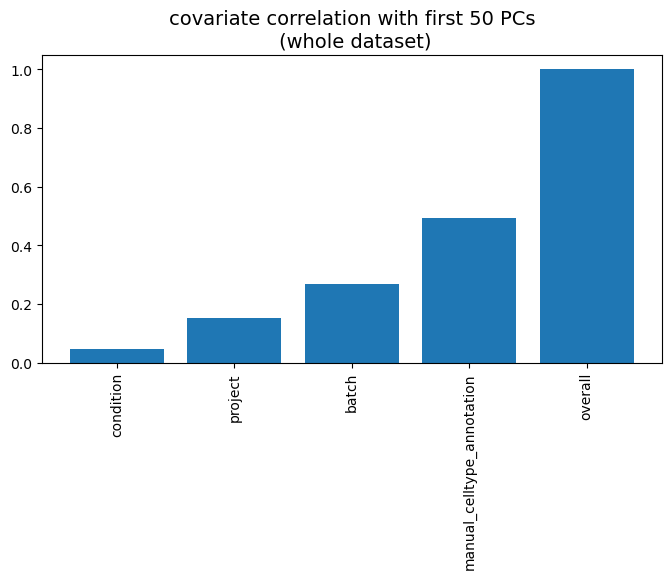

In [280]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

In [244]:
total_variance_explained_clean_sub = total_variance_explained_clean.copy()

In [282]:
groups = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "batch", # ['0_misharin', '0_tsukui', '1_misharin', '1_tsukui', ...,]
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "manual_celltype_annotation",
]

stdev_single_cell_platform_shuffled = {}
for group in groups:
    total_variance_explained_clean[f"shuffled_{group}"] = np.mean(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}_")
            ]
        ]
    )
    
    stdev_single_cell_platform_shuffled[f"shuffled_{group}"] = np.std(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}_")
            ]
        ]
    )


In [283]:
stdev_single_cell_platform_shuffled

{'shuffled_project': 8.543700781851178e-06,
 'shuffled_batch': 3.2009842505307874e-05,
 'shuffled_condition': 2.2969830521275934e-05,
 'shuffled_manual_celltype_annotation': 2.1028169921736176e-05}

Sort results:

In [284]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)

In [297]:
total_variance_explained_clean

overall                                     1.0
manual_celltype_annotation             0.494596
batch                                  0.267586
project                                0.153771
condition                              0.046761
shuffled_batch                         0.000602
shuffled_manual_celltype_annotation     0.00026
shuffled_condition                     0.000054
shuffled_project                       0.000046
dtype: object

Plot:

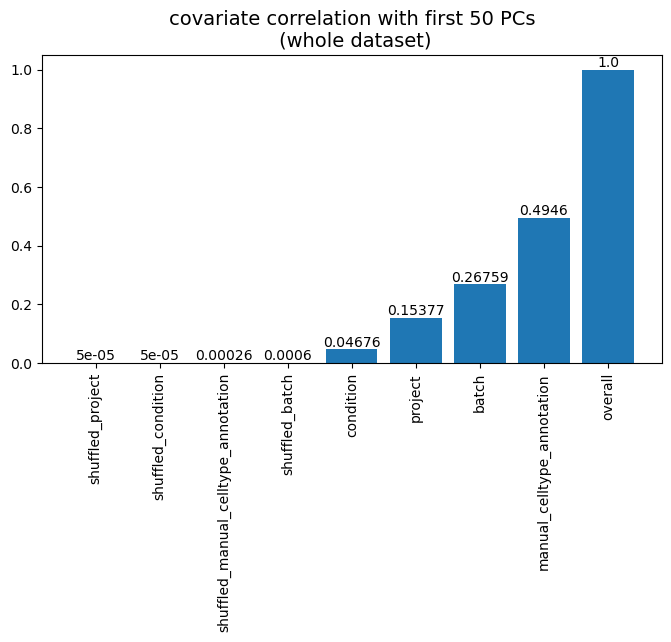

In [317]:
plt.figure(figsize=(8, 4))
rounded_values = total_variance_explained_clean[::-1].values.astype('float').round(5)
plt.bar(
    total_variance_explained_clean[::-1].index,
    rounded_values,
)

# Add rounded numbers on top of the bars
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)
plt.xticks(rotation=90)
plt.show()


Add Combinations: batch-annotation and project-annotation

### Store results:

In [ ]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]


In [320]:
for group in groups:
    res.loc[f"shuffled_{group}", "stdev"] = stdev_single_cell_platform_shuffled[f"shuffled_{group}"]

res

,fraction_of_variance_explained,stdev
overall,1.0,NaN
manual_celltype_annotation,0.494596,NaN
batch,0.267586,NaN
project,0.153771,NaN
condition,0.046761,NaN
shuffled_batch,0.000602,0.000032
shuffled_manual_celltype_annotation,0.00026,0.000021
shuffled_condition,0.000054,0.000023
shuffled_project,0.000046,0.000009


In [321]:
res.to_csv(
    f"{dir_out}/variance_explained_per_covariate.csv"
)

print z-score:

In [322]:
for group in groups:
    print(group)
    print(
        (res.loc["project", "fraction_of_variance_explained"]
        - res.loc[f"shuffled_{group}", "fraction_of_variance_explained"]
        ) / res.loc[f"shuffled_{group}", "stdev"]

    )
    #res.loc[f"shuffled_{group}", "stdev"] = stdev_single_cell_platform_shuffled[f"shuffled_{group}"]

project
17992.821374988507
batch
4785.063746810683
condition
6692.100443839487
manual_celltype_annotation
7300.251766481248
